
## Assignment 5
Perform image segmentation on all images in the dataset, using the normalized cut algorithm running on the top of superpixels rather than on raw pixels. For each image compute an accuracy metric (which one it is up to you to decide) measuring the overlap between the segments identified by NCUT and the ground truth horse semantic segmentation. Provide a table summarizing the average segmentation accuracy on all images, plus present 2 examples of images that are well-segmented (according to the above defined metric).

Hint: in Python, you have an NCut implementation in the scikit-image library; in Matlab, you can use the original NCut implementation here. Superpixels are implemented both in Matlab as well as in OpenCV. Feel free to pickup the implementation you liked most (and motivate the choice).

# Superpixeling 

Superpixeling is a preprocessing step in image segmentation that consists in grouping together similar pixels to perform a cheap, local oversegmentation. The image processing library **scikit-image** was utilized for image processing [1].



Reference:

[1] Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu, and the scikit-image contributors. scikit-image: Image processing in Python. PeerJ 2:e453 (2014) https://doi.org/10.7717/peerj.453


In [79]:
from skimage import segmentation, color, graph
from matplotlib import pyplot as plt
import numpy as np

from utils1 import * # contains methods to import the dataset and print images

In [80]:
# load the dataset
folder_path = '../datasets/weizmann_horse_db/horse'
images = load_images_from_folder(folder_path)

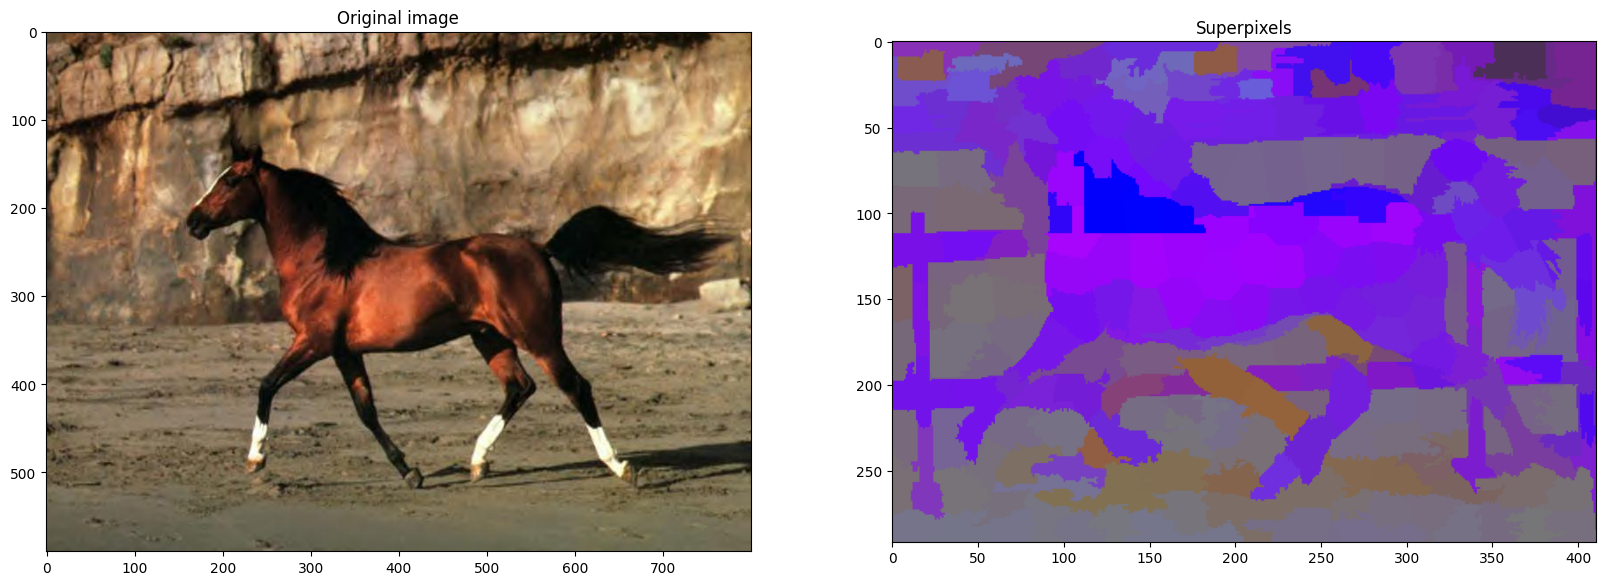

In [117]:
import cv2

image = images[146]

image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

num_superpixels = 300

# Apply SLIC algorithm to generate superpixels
labels = segmentation.slic(image, n_segments=num_superpixels, compactness=20, start_label=1)
color_segment = color.label2rgb(labels, image, kind='avg')

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(images[0])
ax[0].set_title('Original image')
ax[1].imshow(color_segment)
ax[1].set_title('Superpixels')
plt.show()


RAG with 231 nodes and 643 edges
RAG with 231 nodes and 643 edges


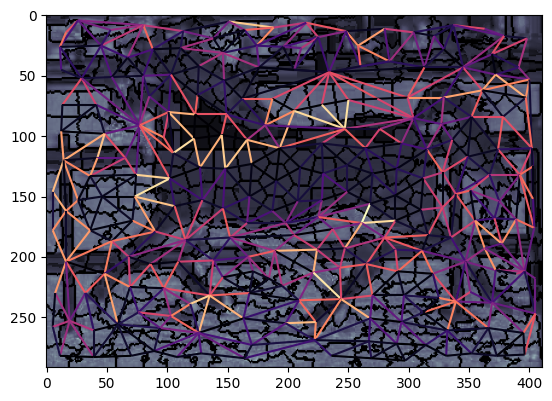

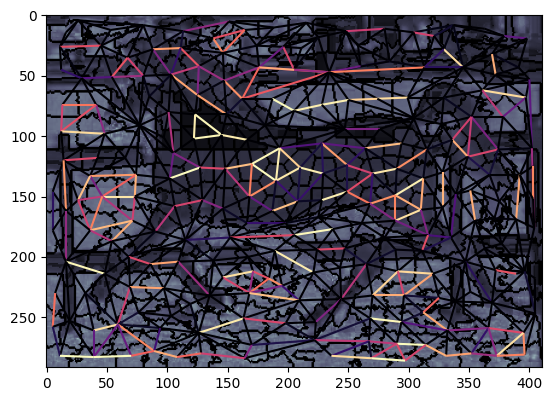

In [118]:
RAG_distance = graph.rag_mean_color(image, labels, mode='distance')
print(RAG_distance)
RAG_similarity = graph.rag_mean_color(image, labels, mode='similarity')
print(RAG_similarity)
graph1 = graph.show_rag(labels=labels, rag=RAG_distance, image=image)
graph2 = graph.show_rag(labels=labels, rag=RAG_similarity, image=image)

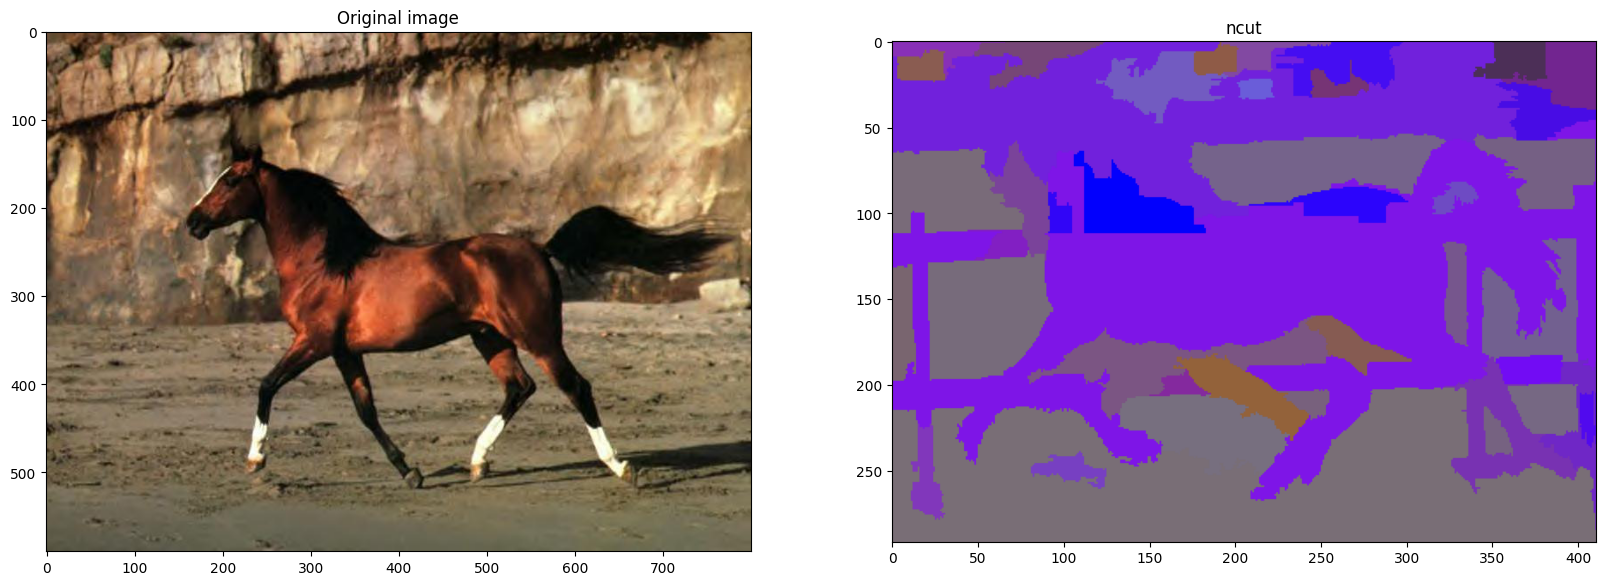

In [130]:
ncut = graph.cut_normalized(labels, rag=RAG_similarity)
color_ncut = color.label2rgb(ncut, image, kind='avg', bg_label=0)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(images[0])
ax[0].set_title('Original image')
ax[1].imshow(color_ncut)
ax[1].set_title('ncut')
plt.show()

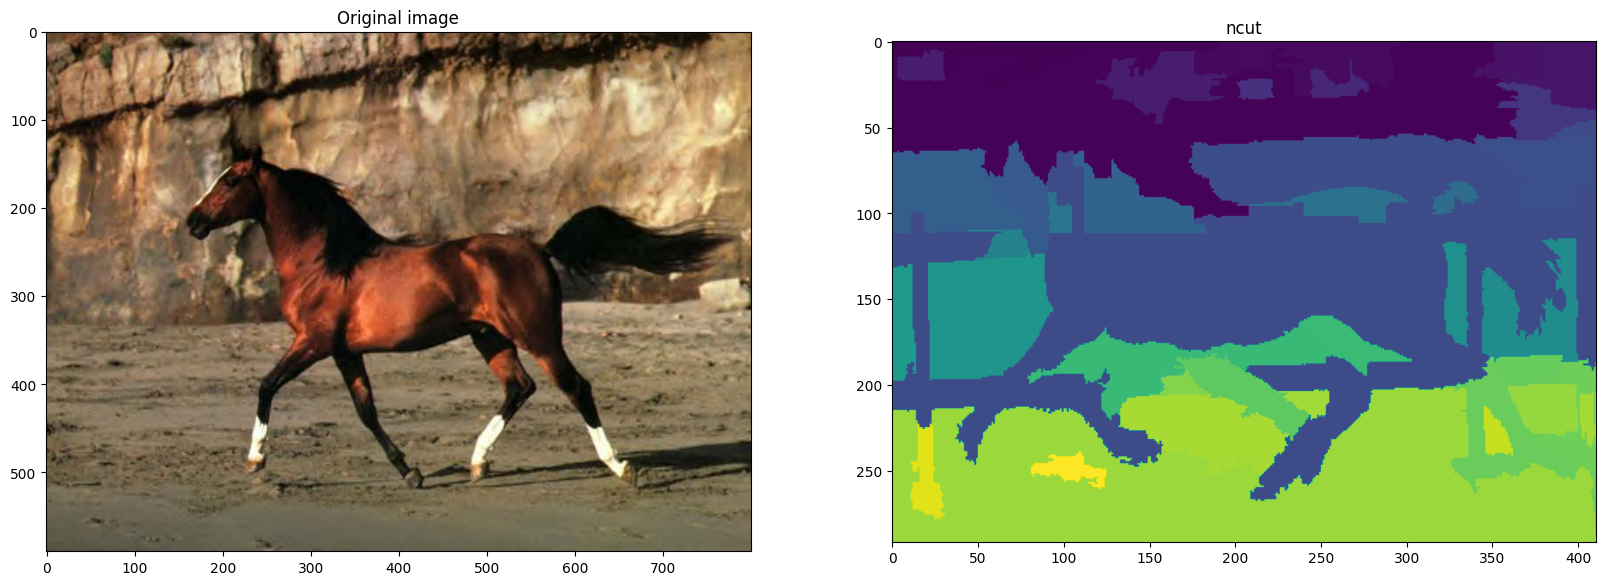

In [131]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(images[0])
ax[0].set_title('Original image')
ax[1].imshow(ncut)
ax[1].set_title('ncut')
plt.show()

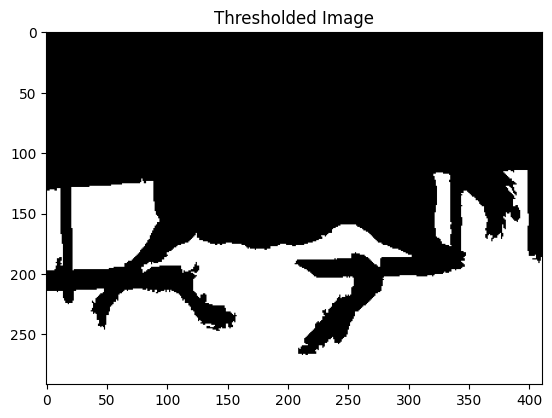

In [128]:
import cv2
segmented_image_gray = ncut.astype(np.uint8)
_, thresholded_image = cv2.threshold(segmented_image_gray, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#print(thresholded_image) with matplotlib

# Display the thresholded image
plt.imshow(thresholded_image, cmap='gray')
plt.title('Thresholded Image')
plt.show()



In [37]:
print(thresholded_image)
# check if thresholded image is binary
print(np.unique(thresholded_image))


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[0 1]


In [109]:
from utils1 import load_images_from_folder
folder_path = '../datasets/weizmann_horse_db/mask'
imagess = load_images_from_folder(folder_path)

In [110]:
from sklearn.metrics import jaccard_score
import numpy as np

img_true=np.array(imagess[0]).ravel()
img_pred=np.array(thresholded_image).ravel()
iou = jaccard_score(img_true, img_pred)

In [111]:
iou

0.4978429608901326

In [18]:
def ncut(image):
    labels = segmentation.slic(image, n_segments=500, compactness=20, start_label=1)
    #color_segment = color.label2rgb(labels, image, kind='avg')

    RAG_similarity = graph.rag_mean_color(image, labels, mode='similarity')
    ncut_ = graph.cut_normalized(labels, rag=RAG_similarity)
    
    segmented_image_gray = ncut_.astype(np.uint8)
    _,  thresholded_image = cv2.threshold(segmented_image_gray, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return thresholded_image

In [19]:
def metric(image, mask):
    ncut_threshold = ncut(image)
    img_true=np.array(mask).ravel()
    img_pred=np.array(ncut_threshold).ravel()
    iou = jaccard_score(img_true, img_pred)
    return iou

In [21]:
from tqdm import tqdm

accs = []

with tqdm(total=10, desc="image", colour='yellow') as pbar:
    for i in range(10):
        accs.append(metric(images[i], imagess[i]))
        pbar.update(1)

image:   0%|          | 0/10 [00:00<?, ?it/s]

image: 100%|██████████| 10/10 [00:47<00:00,  4.73s/it]


In [22]:
accs

[0.4805576400706034,
 0.046376584140934596,
 0.043007545706701664,
 0.09924112567699155,
 0.16559039371327383,
 0.0028026597790844644,
 0.009601645996456536,
 0.2875460107744436,
 0.28057158560043965,
 0.03822799035690334]